# Aproximación del modelo SABR a través de una red neuronal

Objetivo: obtener las volatilidades normales del modelo SABR a partir de sus correspondientes strikes, sus parámetros y el vencimiento de la opción (maturity)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('C:\\Archivos\\TFM\\code')
data = pd.read_csv('Smile_30_4_2019.csv', sep = ',', header = 0, index_col = False, engine = 'python')

Importo y preparo los datos de mercado de los swaptions

In [2]:
data.head()

,Reference,StrikeATMdiff,Forward_Rate,Volatility
0,EUR_1M_1Y,-10,-0.003126,0.000919
1,EUR_1M_1Y,-7,-0.003126,0.000767
2,EUR_1M_1Y,-5,-0.003126,0.000668
3,EUR_1M_1Y,-2,-0.003126,0.000624
4,EUR_1M_1Y,-1,-0.003126,0.000641


In [3]:
data[['Currency','Maturity','IRS_duration']] = data.Reference.str.split("_", expand = True)

In [4]:
matur = data.Maturity.str.extract('(\d+)([MY])', expand = True)

In [5]:
T = []
for i in range(len(matur)):
    if matur.iloc[i,1] == 'M':
        aux = pd.to_numeric(matur.iloc[i,0]) / 12
        T.append(aux)
    else:
        T.append(matur.iloc[i,0])

In [6]:
def strikeABS(K_bps, FR):
    K = FR + K_bps/10000
    return K

length = int(len(data) / 11); Xmarket = np.zeros((length,23))
for i in range(length):
    strike = []; vol = []
    for j in range(11):
        Kaux = strikeABS(pd.to_numeric(data.StrikeATMdiff[j + 11*i]),pd.to_numeric(data.Forward_Rate[j + 11*i]))
        strike.append(Kaux)
        vol.append(pd.to_numeric(data.Volatility[j + 11*i]))
    Xmarket[i,:] = np.hstack((strike,vol, T[11*i]))

## Testeo de la red neuronal con los datos generados por ecuación de Hagan

Se han generado $10^6$ muestras aleatorias del SABR, de las cuales un quinto se utilizan para validar la red neuronal. Esta red toma como inputs los strikes a los que cotizan los swaptions con mismo vencimiento de la opción y del swap, los parámetros del SABR que modelarían su precio y el vencimiento, y devuelve como output volatilidades normales para cada strike.

Por cross validation sobre un nº de capas en el intervalo [3,8] y nº de neuronas por capa en [32, 64, 128, 256] el mejor resultado obtenido es 6 capas con 32 neuronas.

In [7]:
from keras.models import load_model
NN = load_model('paramstovols.h5')
X = np.load('X_sample_vols.npy'); vols = np.load('y_sample_vols.npy');
import SABRnormal

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


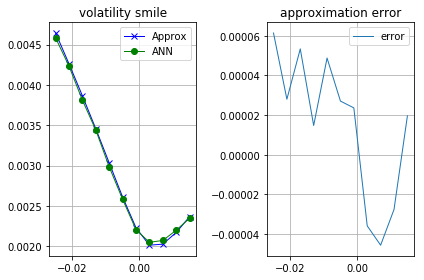

In [46]:
testcase = np.random.randint(0,len(X)) ; Xtestcase = np.ravel(X[-testcase,:]);
testvols = np.ravel(NN.predict(X[-testcase,:].reshape(1,-1)))

plt.figure()
plt.subplot(121)
plt.plot(Xtestcase[:11], vols[-testcase,:], color = 'blue', marker = 'x', linewidth = 1.0);
plt.plot(Xtestcase[:11],testvols, color = 'green', marker = 'o', linewidth = 1.0);
plt.grid(True); plt.legend(['Approx','ANN']); plt.title('volatility smile')

plt.subplot(122)
plt.plot(Xtestcase[:11], (vols[-testcase,:] - testvols), linewidth = 1.0);
plt.grid(True); plt.legend(['error']); plt.title('approximation error')
#plt.gca().set_yticklabels(['{:.2f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
plt.tight_layout()

In [47]:
testsize = 1000; error_test = np.zeros((testsize,11))
for testcase in range(1,testsize + 1):
    Xtestcase = np.ravel(X[-testcase,:]);
    testvols = np.ravel(NN.predict(X[-testcase,:].reshape(1,-1)))
    error_test[testcase-1] = (vols[-testcase,:] - testvols)
RMSE = np.sqrt(np.sum(np.square(error_test), axis = 0)/testsize)
title = np.linspace(-200,200,11)
pd.DataFrame(RMSE.reshape(1,-1),index = None, columns = title)

,-200.0,-160.0,-120.0,-80.0,-40.0,0.0,40.0,80.0,120.0,160.0,200.0
0,0.000084,0.000072,0.000069,0.000065,0.000061,0.00005,0.000059,0.00006,0.000072,0.000077,0.000094


## Calibración del SABR mediante la red neuronal al smile de mercado

In [75]:
from scipy.optimize import minimize
def objfun(param,k,f,t,beta,shift,sigmaMKT):
    """
        Objective function to minimize for calibration while estimating
        the 3 parameters at the same time
    """
    vbles = np.hstack((k,param,t)).reshape(1,-1)
    vols = np.ravel(NN.predict(vbles))
    MSE = np.sum((vols - sigmaMKT)**2)

    return MSE

def calibrate(k,f,t,beta,shift,sigmaMKT,seed):
    """
        Calibration function for the estimation of the 3 parameters at once
    """
    bnd = ( (0.0001, None), (-0.9999, 0.9999), (0.001, None)  )
    res = minimize(objfun, seed, args = (k,f,t,beta,shift,sigmaMKT),
                   bounds = bnd, method = 'L-BFGS-B')
    return res.x


Los datos están organizados de la siguiente forma:
 - Cada fila de la matriz X (dim 15) está organizada como: [11 strikes, $\alpha,\rho,\nu,T$]
 - Cada fila de la matriz vols (dim 11) representa las 11 volatilidades diferentes que son el output de la red

In [90]:
seed = [0.001,0.01,0.01]; testcase = 0
res = calibrate(X[testcase,:11],X[testcase,5],X[testcase,-1],0,0,vols[testcase,:],seed)
print('Estimada:  ' + str(res) + '  ||  Real:  ' + str(X[testcase,11:-1]))

Estimada:  [0.00677761 0.00856332 0.00698075]  ||  Real:  [0.00634096 0.59098086 0.28233639]


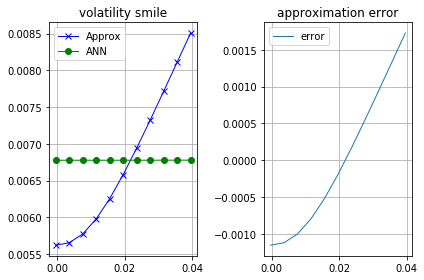

In [91]:
vol_test = []; 
for j in range(11):
    aux = SABRnormal.normal_vol(X[testcase,j],X[testcase,5],X[testcase,-1],res[0],0,res[1],res[2],0)
    vol_test.append(aux)
    
plt.figure()
plt.subplot(121)
plt.plot(Xtestcase[:11], vols[testcase,:], color = 'blue', marker = 'x', linewidth = 1.0);
plt.plot(Xtestcase[:11],vol_test, color = 'green', marker = 'o', linewidth = 1.0);
plt.grid(True); plt.legend(['Approx','ANN']); plt.title('volatility smile')

plt.subplot(122)
plt.plot(Xtestcase[:11], (vols[testcase,:] - vol_test), linewidth = 1.0);
plt.grid(True); plt.legend(['error']); plt.title('approximation error')
#plt.gca().set_yticklabels(['{:.2f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
plt.tight_layout()